In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
# Reading both train and test datasets
train_df = pd.read_csv("diabetes_train.csv",header=0)
test_df = pd.read_csv("diabetes_test.csv",header = 0)

In [5]:
train_df.head()

,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
0,358,13,129,0,30,0,39.9,0.569,44,1
1,74,4,129,86,20,270,35.1,0.231,23,0
2,353,3,61,82,28,0,34.4,0.243,46,0
3,498,2,81,72,15,76,30.1,0.547,25,0
4,146,0,102,75,23,0,0.0,0.572,21,0


In [6]:
test_df.head()

,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age
0,669,6,98,58,33,190,34.0,0.430,43
1,325,2,112,75,32,0,35.7,0.148,21
2,625,2,108,64,0,0,30.8,0.158,21
3,691,8,107,80,0,0,24.6,0.856,34
4,474,7,136,90,0,0,29.9,0.210,50


In [7]:
# Checking for missing data in train dataset
pd.DataFrame(train_df).isna().sum()

Id                    0
num_times_pregnant    0
plasma_glucose        0
DBP                   0
triceps_skin          0
serum_insulin         0
BMI                   0
pedigree              0
age                   0
diabetes              0
dtype: int64

No missing data

In [8]:
# Checking for missing data in train dataset
pd.DataFrame(test_df).isna().sum()

Id                    0
num_times_pregnant    0
plasma_glucose        0
DBP                   0
triceps_skin          0
serum_insulin         0
BMI                   0
pedigree              0
age                   0
dtype: int64

No missing data

# Data Exploration

0    377
1    199
Name: diabetes, dtype: int64

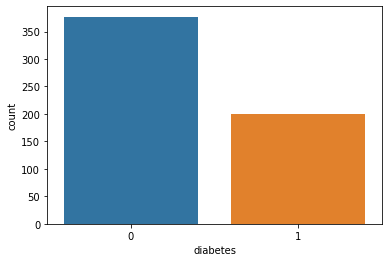

In [9]:
sns.countplot(x="diabetes",data = train_df)
train_df["diabetes"].value_counts()

Target is imbalanced with 34.5% having diabetes

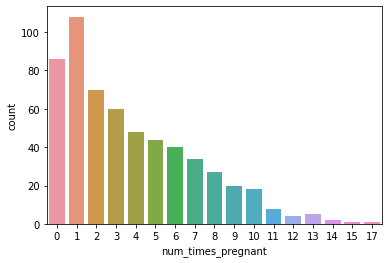

In [10]:
sns.countplot(x="num_times_pregnant",data=train_df)

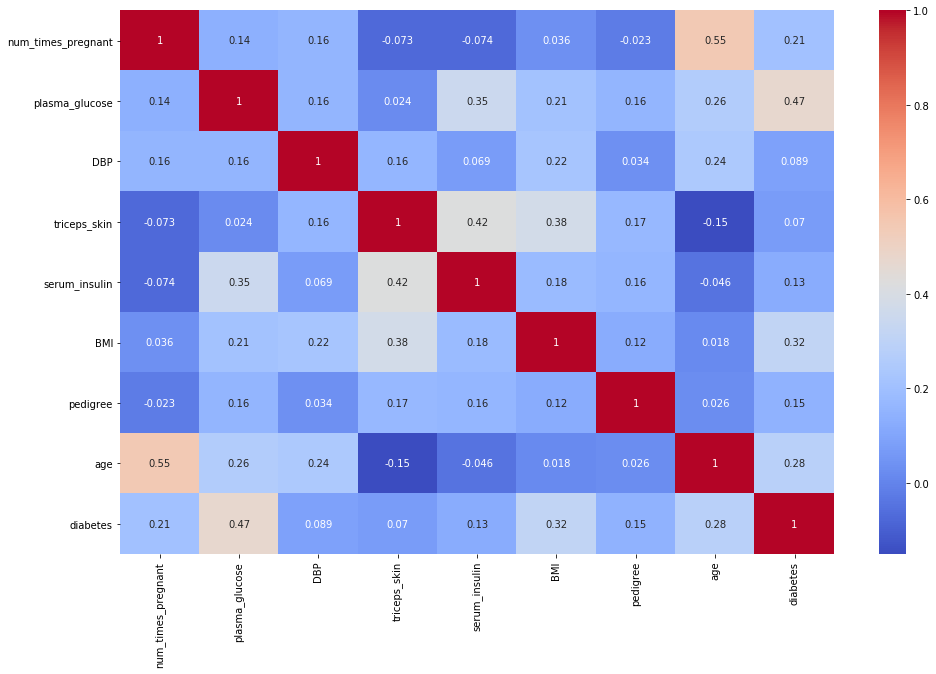

In [11]:
# Checking for correaltion among the features
# Heatplot to see the correlation between different features
train_df.drop("Id",axis=1,inplace=True)
plt.figure(figsize=(16,10))
sns.heatmap(train_df.corr(),cmap='coolwarm',annot=True)

# Feature Engineering

In [12]:
train_df.columns

Index(['num_times_pregnant', 'plasma_glucose', 'DBP', 'triceps_skin',
       'serum_insulin', 'BMI', 'pedigree', 'age', 'diabetes'],
      dtype='object')

In [13]:
# Feature Engineering in train dataset
# 1. Not normal when BMI > 30 and plasma glucose > 126.
# 2. Not normal when diastolic blood pressure > 90 and serum insulin > 126.
train_df["obese_highGlucose"] = np.where((train_df["BMI"] > 30) & (train_df["plasma_glucose"] > 126),"Not Normal","Normal")
train_df["pressure_highInsulin"] = np.where((train_df["DBP"] > 90) & (train_df["serum_insulin"] > 126),"Not Normal","Normal")

In [14]:
# Feature Engineering in train dataset
test_df["obese_highGlucose"] = np.where((test_df["BMI"] > 30) & (test_df["plasma_glucose"] > 126),"Not Normal","Normal")
test_df["pressure_highInsulin"] = np.where((test_df["DBP"] > 90) & (test_df["plasma_glucose"] > 126),"Not Normal","Normal")

In [15]:
train_df.head()

,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes,obese_highGlucose,pressure_highInsulin
0,13,129,0,30,0,39.9,0.569,44,1,Not Normal,Normal
1,4,129,86,20,270,35.1,0.231,23,0,Not Normal,Normal
2,3,61,82,28,0,34.4,0.243,46,0,Normal,Normal
3,2,81,72,15,76,30.1,0.547,25,0,Normal,Normal
4,0,102,75,23,0,0.0,0.572,21,0,Normal,Normal


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_times_pregnant    576 non-null    int64  
 1   plasma_glucose        576 non-null    int64  
 2   DBP                   576 non-null    int64  
 3   triceps_skin          576 non-null    int64  
 4   serum_insulin         576 non-null    int64  
 5   BMI                   576 non-null    float64
 6   pedigree              576 non-null    float64
 7   age                   576 non-null    int64  
 8   diabetes              576 non-null    int64  
 9   obese_highGlucose     576 non-null    object 
 10  pressure_highInsulin  576 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 49.6+ KB


In [17]:
# Changing to categorical
categorical_features = [
    'obese_highGlucose',
    'pressure_highInsulin',
    ]

for categorical_feature in categorical_features:
    train_df[categorical_feature] = train_df[categorical_feature].astype('category')

In [18]:
# Changing to categorical
categorical_features = [
    'obese_highGlucose',
    'pressure_highInsulin',
    ]

for categorical_feature in categorical_features:
    test_df[categorical_feature] = test_df[categorical_feature].astype('category')

In [19]:
#0ne hot encoding for train dataset
train_df = pd.get_dummies(train_df, columns = train_df.select_dtypes(exclude=['int64','int32','float64']).columns, drop_first = True)
train_df.head()

,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes,obese_highGlucose_Not Normal,pressure_highInsulin_Not Normal
0,13,129,0,30,0,39.9,0.569,44,1,1,0
1,4,129,86,20,270,35.1,0.231,23,0,1,0
2,3,61,82,28,0,34.4,0.243,46,0,0,0
3,2,81,72,15,76,30.1,0.547,25,0,0,0
4,0,102,75,23,0,0.0,0.572,21,0,0,0


In [20]:
#0ne hot encoding for test dataset
test_df = pd.get_dummies(test_df, columns = test_df.select_dtypes(exclude=['int64','int32','float64']).columns, drop_first = True)
test_df.head()

,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,obese_highGlucose_Not Normal,pressure_highInsulin_Not Normal
0,669,6,98,58,33,190,34.0,0.430,43,0,0
1,325,2,112,75,32,0,35.7,0.148,21,0,0
2,625,2,108,64,0,0,30.8,0.158,21,0,0
3,691,8,107,80,0,0,24.6,0.856,34,0,0
4,474,7,136,90,0,0,29.9,0.210,50,0,0


# Predictive Modeling

In [21]:
#The target variable Purchase will be y and the other features will be X
y = train_df['diabetes']
X = train_df.drop(columns = 'diabetes')

In [22]:
# The data is now split into train and test in 80:20 ratio.
# The train set will be used to create and train the model while the test data set will be used to validate the model.
#A random seed is selected so that the train and test sets remains constant everytime we split the data.

np.random.seed(42)
# split the data randomly into 80% train and 20% test samples 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20,stratify=y)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Lets check the results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(460, 10)
(116, 10)
(460,)
(116,)


# Data balancing in the X_train using SMOTE

In [23]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 159
Before OverSampling, counts of label '0': 301 



In [24]:
sm = SMOTE(random_state=42)
X_res,y_res = SMOTE(random_state=42).fit_resample(X_train,y_train)

In [25]:
print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_res==0)))

After OverSampling, counts of label '1': 301
After OverSampling, counts of label '0': 301 



In [26]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

In [27]:
# F1 Score
def F1_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    recall = (tp/(tp+fn))
    precision = (tp/(tp+fp))
    return (2*recall*precision)/(recall+precision)

In [28]:
# Keeping threshold as 0.5 initially. Can change if required to improve F1 score
class_threshold = 0.5

# Model No 1: Random Forest

In [29]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=42)

# Train the model classifier_RF on the training data after balancing
classifier_RF.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

Metrics of the Random Forest model: 

Confusion matrix: 
[[58  8]
 [18 32]]
                                   Accuracy: 0.7758620689655172
                   SENSITIVITY (aka RECALL): 0.8
                 SPECIFICITY (aka FALL-OUT): 0.7631578947368421
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.64
                 NEGATIVE PREDICTIVE VALUE): 0.8787878787878788
                                  F1 Score): 0.7111111111111111


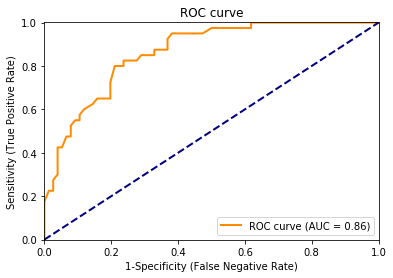

 AUC: 0.8643092105263158


In [30]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))
print("                                  F1 Score): " + str(F1_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [31]:
# Another way of checking F1 and other metrics
from sklearn.metrics import classification_report, f1_score

print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred)))
print()
print(classification_report(y_test, y_pred))

F1 Score = 0.71

              precision    recall  f1-score   support

           0       0.88      0.76      0.82        76
           1       0.64      0.80      0.71        40

    accuracy                           0.78       116
   macro avg       0.76      0.78      0.76       116
weighted avg       0.80      0.78      0.78       116



[0.06115538 0.22549859 0.09145307 0.06894115 0.06067616 0.1631042
 0.11501451 0.16627261 0.04725116 0.00063318]


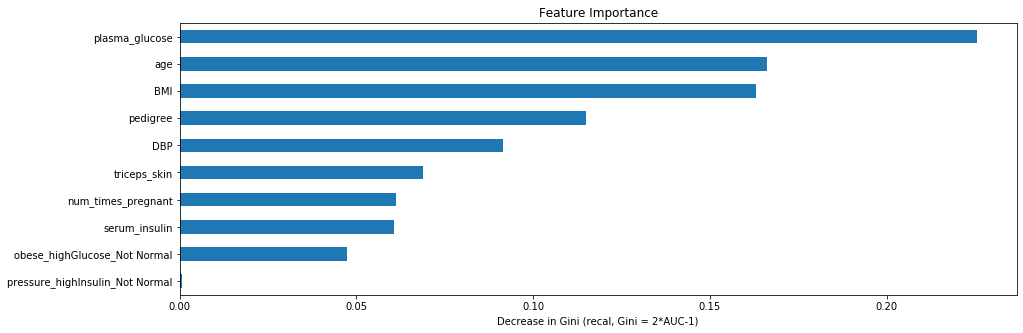

In [32]:
# Tree models do not have coefficients, but have easily-interpretable tree plots
# But in tree ensembles (such as random forect) there is no point to look at individual trees

# calculate feature importances
importance = classifier_RF.feature_importances_ 
print(importance)

feature_imp = pd.Series(classifier_RF.feature_importances_,index=X_res.columns).sort_values(ascending=False)
# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_res.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

# Prediction using RF Model

In [33]:
# Using the test file to predict final results for submission
X_predict = test_df.drop(["Id"], axis=1)

# Use your model to make predictions
pred_test = classifier_RF.predict(X_predict)

# We will look at the predicted prices to ensure we have something sensible.
print(pred_test)

my_submission = pd.DataFrame({'Id': test_df.Id, 'Predicted': pred_test})

my_submission.head()

# you could use any filename. We choose submission here
my_submission.to_csv('Diabetes_Submission_RF', index=False)

[0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1
 0 0 0 1 1 0 0]


# Model No 2: XgBoost

In [41]:
# Define the gradient boosting machine model and call it classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=42)

# Train the model classifier_GBM on the training data
classifier_GBM.fit(X_res, y_res)

# A gradient boosting model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble, 
# -- speed of boosting ("learning rate", "decay rate"), 
# -- max number of leafs on each tree, 
# -- min number of datapoints at a leaf
# and so on

GradientBoostingClassifier(random_state=42)

Metrics of the Gradient Boosting Machine model: 

Confusion matrix: 
[[62  8]
 [14 32]]
                                   Accuracy: 0.8103448275862069
                   SENSITIVITY (aka RECALL): 0.8
                 SPECIFICITY (aka FALL-OUT): 0.8157894736842105
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6956521739130435
                 NEGATIVE PREDICTIVE VALUE): 0.8857142857142857
                                  F1 Score): 0.7441860465116279


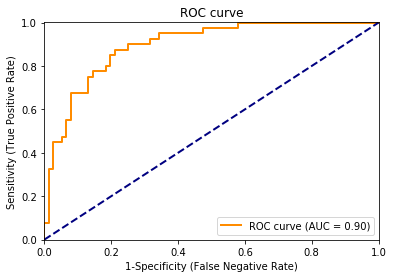

 AUC: 0.8950657894736842


In [42]:
# Use the trained model to predict testing data
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))
print("                                  F1 Score): " + str(F1_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

In [43]:
# Another way of checking F1 and other metrics
from sklearn.metrics import classification_report, f1_score

print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred)))
print()
print(classification_report(y_test, y_pred))

F1 Score = 0.74

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        76
           1       0.70      0.80      0.74        40

    accuracy                           0.81       116
   macro avg       0.79      0.81      0.80       116
weighted avg       0.82      0.81      0.81       116



[0.02874915 0.365043   0.0370915  0.04061269 0.04074091 0.18171132
 0.11679085 0.187833   0.00090625 0.00052134]


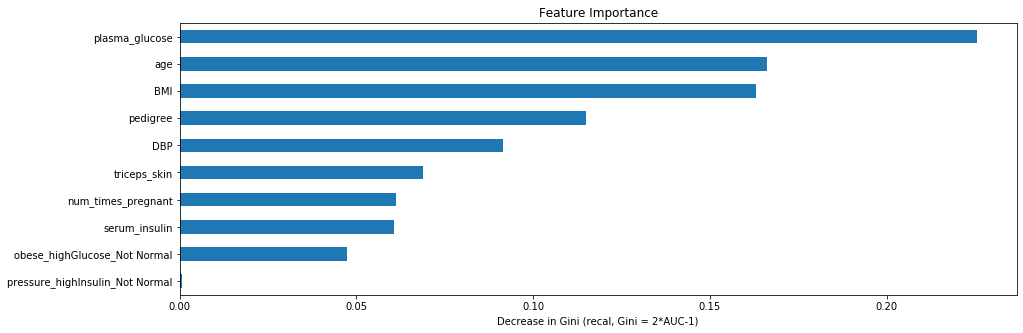

In [44]:
# Tree models do not have coefficients, but have easily-interpretable tree plots
# But in tree ensembles (such as random forect) there is no point to look at individual trees

# calculate feature importances
importance = classifier_GBM.feature_importances_ 
print(importance)

feature_imp = pd.Series(classifier_RF.feature_importances_,index=X_res.columns).sort_values(ascending=False)
# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_res.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

Optimized hyper-parameters:{'learning_rate': 0.1, 'max_depth': 6, 'max_leaf_nodes': 50, 'n_estimators': 100}
Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": 

Confusion matrix: 
[[60  9]
 [16 31]]
                                   Accuracy: 0.7844827586206896
                   SENSITIVITY (aka RECALL): 0.775
                 SPECIFICITY (aka FALL-OUT): 0.7894736842105263
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.6595744680851063
                 NEGATIVE PREDICTIVE VALUE): 0.8695652173913043
                                  F1 Score): 0.7126436781609196


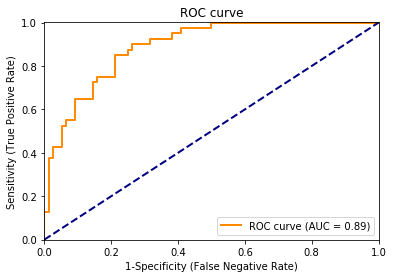

 AUC: 0.8904605263157894


In [45]:
# Hyperparameter tuning
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(f1_score, greater_is_better=True)

# as an example, we will tune two parameters
n_trees = [100, 200, 300, 400, 500, 600] # first, the "numeber of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
learning_rates = [0.01, 0.1] # second, speed of boosting ("learning rate") and we will use two values 0.01 и 0.1
depth = [2, 3, 4, 5, 6]
leaf_nodes = [None,5, 10, 50, 100]

Grid_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates,
                                'max_depth':depth,'max_leaf_nodes':leaf_nodes}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_GBM, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# # apply function grid_search to the training data, call the resultant best model grid_search_GBM
grid_search_GBM = grid_search.fit(X_res, y_res)

# use the best model to predict the testing data 
y_pred_prob = grid_search_GBM.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))

# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model with the optimized hyper-parameters": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))
print("                                  F1 Score): " + str(F1_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

The model without tuning has a better F1 than the tuned model. So the untuned model will be used to predict results.

# Prediction using XgBoost

In [47]:
# Using the test file to predict final results for submission
X_predict = test_df.drop(["Id"], axis=1)

# Use your model to make predictions
pred_test = classifier_GBM.predict(X_predict)

# We will look at the predicted prices to ensure we have something sensible.
print(pred_test)

my_submission = pd.DataFrame({'Id': test_df.Id, 'Predicted': pred_test})

my_submission.head()

# you could use any filename. We choose submission here
my_submission.to_csv('Diabetes_Submission_xgboost', index=False)

[0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1
 0 0 0 1 1 0 0]


# Model No 3: Step wise Logistic Regression

In [38]:
# Apply variable selection with Stepwise Recursive Feature Selection 

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=20, step=1) # in this example we will select 20 variables; this number "20" is a hyperparameter to tune
rfe.fit(X_train, y_train)
ranking = rfe.ranking_.reshape(len(X_train.columns))

# which 5 variables are in the model?
pd.DataFrame([X_test.columns,ranking]).transpose().sort_values(1).head()

C:\Users\ari62\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,0,1
0,num_times_pregnant,1
1,plasma_glucose,1
2,DBP,1
3,triceps_skin,1
4,serum_insulin,1


Metrics of the logistic regression model after variable selection: 

Confusion matrix: 
[[68 17]
 [ 8 23]]
                                   Accuracy: 0.7844827586206896
                   SENSITIVITY (aka RECALL): 0.575
                 SPECIFICITY (aka FALL-OUT): 0.8947368421052632
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.7419354838709677
                 NEGATIVE PREDICTIVE VALUE): 0.8
                                  F1 Score): 0.6478873239436619


C:\Users\ari62\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


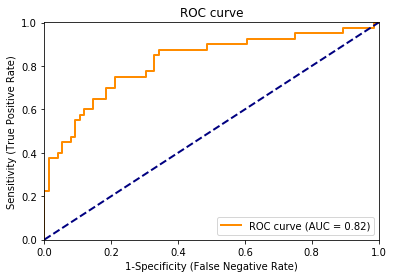

 AUC: 0.8190789473684209


In [39]:
# Train the model and call it classifier_LR_RFE 
classifier_LR_RFE = rfe.fit(X_train, y_train)

# Use the trained model to predict testing data
y_pred_prob = classifier_LR_RFE.predict_proba(X_test)[:,1] # probabilities
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification


# Lets look at the model metrics after variable selection 
print('Metrics of the logistic regression model after variable selection: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))


print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))
print("                                  F1 Score): " + str(F1_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Prediction using Logistic model

In [40]:
# Using the test file to predict final results for submission
X_predict = test_df.drop(["Id"], axis=1)

# Use your model to make predictions
pred_test = classifier_LR_RFE.predict(X_predict)

# We will look at the predicted prices to ensure we have something sensible.
print(pred_test)

my_submission = pd.DataFrame({'Id': test_df.Id, 'Predicted': pred_test})

my_submission.head()

# you could use any filename. We choose submission here
my_submission.to_csv('Diabetes_Submission_Logit', index=False)

[0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1
 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1
 0 0 0 1 0 0 0]
